In [1]:
import src.database
from src.Dataset import Dataset
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import src.plot
import shap
import os
from src import featureselection

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb

# 1. Univariate Feature Selection (Korrelationskoeffizient)

## Korrelations - Heatmap

### Lineare Korrelationszusammenhänge (Heatmap)

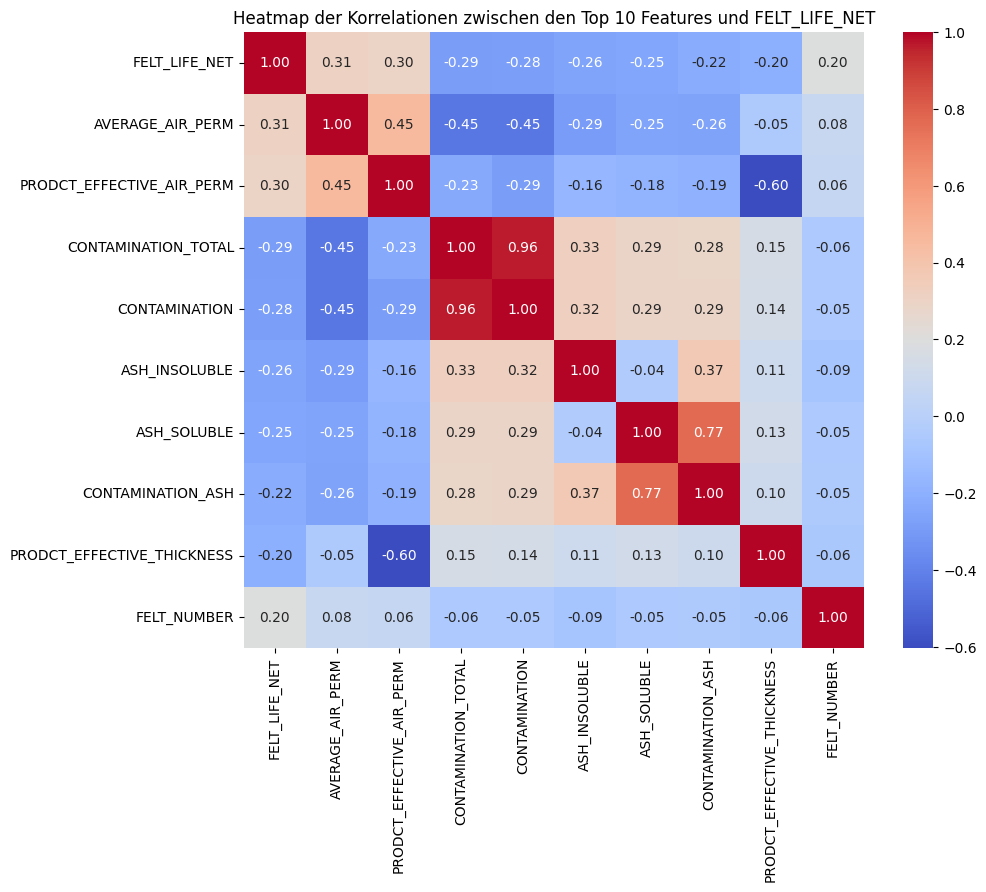

In [2]:
#Vorverarbeitete Daten aus CSV auslesen
df = pd.read_csv("data/df_preprocessed_all.csv", sep = ",")
df = df.drop(columns=['FELT_LIFE','REMOVAL_DATE', 'INSTALLATION_DATE', 'REPORT_DATE'])

#Das Label nennen
label = df.columns.get_loc('FELT_LIFE_NET')

N = 10
correlations = df.corrwith(df['FELT_LIFE_NET'], method='pearson')
correlation_df = pd.DataFrame({'Correlation': correlations})
correlation_df = correlation_df.abs().sort_values(by='Correlation', ascending=False)
top_features = correlation_df.index[:N]
# Erstelle eine Heatmap der korrelierten Features
plt.figure(figsize=(10, 8))
sns.heatmap(df[top_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap der Korrelationen zwischen den Top {} Features und {}'.format(N, "FELT_LIFE_NET"))
plt.show()

### Vorhersage mit unterschiedlicher Feature Anzahl

In [3]:
#Vorverarbeitete Daten aus CSV auslesen
df = pd.read_csv("data/df_preprocessed_all.csv", sep = ",")
df = df.drop(columns=['FELT_LIFE','REMOVAL_DATE', 'INSTALLATION_DATE', 'REPORT_DATE'])

#Das Label nennen
label = df.columns.get_loc('FELT_LIFE_NET')
header = df.columns

#Machine Learning Algorithms die benutzt werden
MLA = [
    ('Linear Regressor',LinearRegression()),
    ('SVR', SVR()),
    ('Random Forest',RandomForestRegressor()),
    ('Gradient Boosting', xgb.XGBRegressor())
]

feature_counts = [
    10, 
    20, 
    30, 
    40
]

results_corr = {}
predictions_corr = {}

for num_features in feature_counts:
    
     # Initialisiere Ergebnisse und Predictions
    results_corr[num_features] = {}
    predictions_corr[num_features] = {}
    
    # Für alle Modelle in MLA FS mit Korrelationskeoffizienten mit anschließender Validierung
    for model_name, model_instance in MLA:

        dataset = Dataset(df, 'df', label, divide_dataset=False, header=header)
        dataset.divide_dataset(model_instance ,normalize=False, all_features=True, all_instances=True, evaluate=False, folds=5)

        #FS mit Korrelationskoeffizient
        selected_features, duration = featureselection.correlation(dataset.get_X_train(), dataset.get_y_train(), num_features=num_features)
        dataset.set_features(selected_features)

        #Regressor trainieren
        dataset.fit_classifier()

        # Cross-Validation
        dataset.set_CV()
        cv = dataset.get_CV()

        #Validierung auf Testset
        dataset.set_train_metrics()
        train = dataset.get_train_metrics()
        traintime = dataset.get_traintime()

       

        dataset.set_test_metrics()
        test = dataset.get_test_metrics()



        #dataset.plot_shapley_values("FS_corr_"+model_name)

        results_corr[num_features][model_name] = {
            'Model_name': model_name,
            'CV_TrainMAE': cv['CV_TrainMAE'],
            'CV_TrainRMSE': cv['CV_TrainRMSE'],
            'CV_TestMAE': cv['CV_TestMAE'],
            'CV_TestRMSE': cv['CV_TestRMSE'],
            'CV_fit_time': cv['CV_fit_time'],
            'CV_fit_time_ges':cv['CV_fit_time']+duration,
            'TrainRMSE': train['TrainRMSE'],
            'TrainMAE': train['TrainMAE'],
            'TestRMSE': test['TestRMSE'],
            'TestMAE': test['TestMAE'],
            'TrainTime': traintime,
            'TrainTime_ges': traintime+duration,
            'Features': selected_features,
            'Feature-Anzahl': num_features,
            'FS-Laufzeit': duration
        }

        predictions_corr[num_features][model_name] = {
        'Model_name': model_name,
        'y_train': dataset.get_y_train(),
        'y_test': dataset.get_y_test(),
        'pred_train': dataset.get_y_pred_train(),
        'pred_test':dataset.get_y_pred_test()
        }
        print(f"Finished: Model {model_name}, Feature-Anzahl: {num_features}")
        
# Ergebnisse für alle Features und Modelle
output_dir = "data/Corr/"
os.makedirs(output_dir, exist_ok=True)

for num_features, models_results in results_corr.items():
        # 1. Speichern der Metriken im gewünschten Format
        df_metrics = pd.DataFrame(models_results).transpose()
        df_metrics.to_csv(f'{output_dir}{num_features}_Corr_metrics.csv', index=False)
        
        # 2. Speichern der Vorhersagen im flachen Format
        flattened_predictions = []
        for model_name, data in predictions_corr[num_features].items():
            for data_type, values in data.items():
                if data_type != 'Model_name':  # Überspringe das Model_name-Feld
                    for value in values:
                        flattened_predictions.append({
                            'Model_name': model_name,
                            'Data_type': data_type,
                            'Value': value
                        })
        df_predictions = pd.DataFrame(flattened_predictions)
        df_predictions.to_csv(f'{output_dir}{num_features}_Corr_predictions.csv', index=False)
        
        # 3. Speichern der ausgewählten Features exakt wie im Originalformat
        df_features_corr = pd.DataFrame()
        for model_name, model_instance in MLA:
            df_features_corr[model_name] = df.columns[models_results[model_name]['Features']].tolist()
            
        df_features_corr.to_csv(f'{output_dir}{num_features}_Corr_Features.csv', index=False)

        print(f"Saved metrics, predictions, and features for {num_features} features.")


Finished: Model Linear Regressor, Feature-Anzahl: 10
Finished: Model SVR, Feature-Anzahl: 10
Finished: Model Random Forest, Feature-Anzahl: 10
Finished: Model Gradient Boosting, Feature-Anzahl: 10
Finished: Model Linear Regressor, Feature-Anzahl: 20
Finished: Model SVR, Feature-Anzahl: 20
Finished: Model Random Forest, Feature-Anzahl: 20
Finished: Model Gradient Boosting, Feature-Anzahl: 20
Finished: Model Linear Regressor, Feature-Anzahl: 30
Finished: Model SVR, Feature-Anzahl: 30
Finished: Model Random Forest, Feature-Anzahl: 30
Finished: Model Gradient Boosting, Feature-Anzahl: 30
Finished: Model Linear Regressor, Feature-Anzahl: 40
Finished: Model SVR, Feature-Anzahl: 40
Finished: Model Random Forest, Feature-Anzahl: 40
Finished: Model Gradient Boosting, Feature-Anzahl: 40
Saved metrics, predictions, and features for 10 features.
Saved metrics, predictions, and features for 20 features.
Saved metrics, predictions, and features for 30 features.
Saved metrics, predictions, and featur

# 2. Rekursive Feature Elimination (RFE)

## Grafik RFE Evaluationsproblem

(8796, 474)
25
50
75
100
125
150
175
200


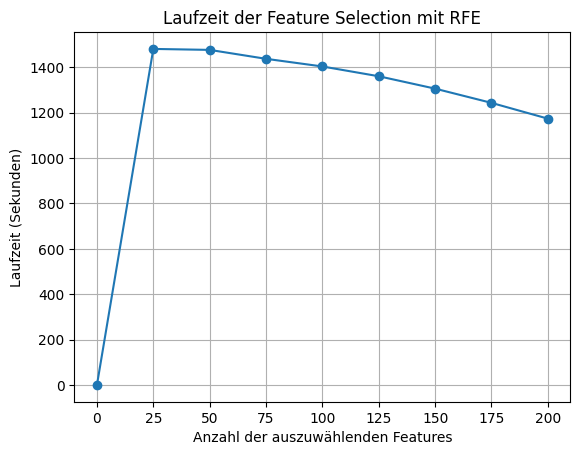

In [2]:
#Vorverarbeitete Daten aus CSV auslesen
df = pd.read_csv("data/df_preprocessed_all.csv", sep = ",")
print(df.shape)
#Das Label nennen
label = df.columns.get_loc('FELT_LIFE_NET')
header = df.columns

#Machine Learning Algorithms die benutzt werden
MLA = [
    #('Linear Regressor',LinearRegression()),
    #('SVR', SVR(kernel='linear')),
    #('Random Forest',RandomForestRegressor()),
    ('Gradient Boosting', xgb.XGBRegressor())
]


for model_name, model_instance in MLA:
    
    dataset = Dataset(df, 'df', label, divide_dataset=False, header=header)
    dataset.divide_dataset(model_instance, all_features=True, all_instances=True, evaluate=False, folds=5)
    
    X = dataset.get_X_train()
    y = dataset.get_y_train()
    max_features = 200
    featureselection. visualize_rfe_runtime(model_instance, X, y, max_features, step=25, time_limit=10000)

## Einzelner Evaluationsschritt

### Code

In [ ]:
#Vorverarbeitete Daten aus CSV auslesen
df = pd.read_csv("data/df_preprocessed_all.csv", sep = ",")

#Das Label nennen
label = df.columns.get_loc('FELT_LIFE_NET')
header = df.columns

#Machine Learning Algorithms die benutzt werden
MLA = [
    ('Linear Regressor',LinearRegression()),
    ('SVR', SVR(kernel='linear')),
    ('Random Forest',RandomForestRegressor()),
    ('Gradient Boosting', xgb.XGBRegressor())
]

results_rfe = {}
predictions_rfe = {}

# Für alle Modelle in MLA FS mit Korrelationskeoffizienten mit anschließender Validierung
for model_name, model_instance in MLA:
    
    dataset = Dataset(df, 'df', label, divide_dataset=False, header=header) 
    dataset.divide_dataset(model_instance, all_features=True, all_instances=True, evaluate=False, folds=5)
    
    #FS mit RFE
    selected_features, num_selected_features, duration = featureselection.rfe(model_instance, dataset.get_X_train(), dataset.get_y_train(), n_features_to_select=40, step=1)
    dataset.set_features(selected_features)
    
    #Regressor trainieren
    dataset.fit_regressor()
    
    # Cross-Validation
    dataset.set_CV()
    cv = dataset.get_CV()
    
    #Validierung auf Validation- und Testset
    dataset.set_train_metrics()
    train = dataset.get_train_metrics()
    traintime = dataset.get_traintime()
    
    
    dataset.set_test_metrics()
    test = dataset.get_test_metrics()
    
    #dataset.plot_shapley_values("FS_corr_"+model_name)
    
    results_rfe[model_name] = {
        'Model_name': model_name,
        'CV_TrainMAE': cv['CV_TrainMAE'],
        'CV_TrainRMSE': cv['CV_TrainRMSE'],
        'CV_TestMAE': cv['CV_TestMAE'],
        'CV_TestRMSE': cv['CV_TestRMSE'],
        'CV_fit_time': cv['CV_fit_time'],
        'CV_fit_time_ges':cv['CV_fit_time']+duration,
        'TrainRMSE': train['TrainRMSE'],
        'TrainMAE': train['TrainMAE'],
        'TestRMSE': test['TestRMSE'],
        'TestMAE': test['TestMAE'],
        'TrainTime': traintime,
        'TrainTime_ges': traintime+duration,
        'Features': selected_features,
        'Feature-Anzahl': num_selected_features,
        'FS-Laufzeit': duration
    }
    
    predictions_rfe[model_name] = {
    'Model_name': model_name,
    'y_train': dataset.get_y_train(),
    'y_test': dataset.get_y_test(),
    'pred_train': dataset.get_y_pred_train(),
    'pred_test':dataset.get_y_pred_test()
    }

df_rfe = pd.DataFrame(results_rfe)
df_rfe = df_rfe.transpose()
df_rfe.to_csv('data/RFE/All_FS_rfe_metrics.csv', index=False)

# Features der RFE speichern
df_features_rfe = pd.DataFrame()
# Iteration über die Modelle und Hinzufügen der Feature-Namen in df_features_rfe
for model_name, model_instance in MLA:
    selected_features = df.columns[results_rfe[model_name]['Features']].tolist()
    
    # Die ausgewählten Spaltennamen in eine neue Spalte in df_features_rfe einfügen
    df_features_rfe[model_name] = selected_features

df_features_rfe.to_csv('data/RFE/All_FS_rfe_Features.csv', index=False)

#Predictions speichern
rfe_data = []
# Iteriere über die Modelle und ihre Daten
for model_name, data in predictions_rfe.items():
    model_data = data.copy()
    model_data.pop('Model_name')  # Entferne den Eintrag 'Model_name'
    for data_type, values in model_data.items():
        # Iteriere über die Werte in jedem Datenfeld und füge sie zur flattened_data-Liste hinzu
        for value in values:
            rfe_data.append({'Model_name': model_name, 'Data_type': data_type, 'Value': value})


df = pd.DataFrame(rfe_data)
df.to_csv('data/RFE/All_FS_rfe_predictions.csv', index=False)

# 3. Feature Importance Tree

In [ ]:
#Vorverarbeitete Daten aus CSV auslesen
df = pd.read_csv("data/df_preprocessed_all.csv", sep = ",")
df = df.drop(columns=['FELT_LIFE','REMOVAL_DATE', 'INSTALLATION_DATE', 'REPORT_DATE'])

#Das Label nennen
label = df.columns.get_loc('FELT_LIFE_NET')
header = df.columns

#Machine Learning Algorithms die benutzt werden
MLA = [
    ('Linear Regressor', LinearRegression()),
    ('SVR', SVR()),
    ('Random Forest', RandomForestRegressor()),
    ('Gradient Boosting', xgb.XGBRegressor())
]

# Feature-Anzahlen, die getestet werden sollen
feature_counts = [
    10, 
    20, 
    30, 
    40
]

all_results = {}  # Speichert Ergebnisse für jede Feature Anzahl
all_predictions = {}  # Speichert Predictions für jede Feature Anzahl

for num_features in feature_counts:
    
    # Initialisiere Ergebnisse und Predictions für die aktuelle Hauptkomponentenanzahl
    all_results[num_features] = {}
    all_predictions[num_features] = {}
    
    # Für alle Modelle in MLA Trainvalidierung, Cross-Validierung und Testvalidierung 
    for model_name, model_instance in MLA:
        
        #Dataset vorbereiten
        dataset = Dataset(df, 'df', label, divide_dataset=False, header=header)
        dataset.divide_dataset(model_instance, normalize=False, shuffle=True, all_features=True, all_instances=True, evaluate=False, partial_sample=False,folds=5)

        selected_features, feature_importances, duration = featureselection.rf_feature_selection(dataset.get_X_train(), dataset.get_y_train(), num_features)
        
        dataset.set_features(selected_features)
    
        #Regressor trainieren
        dataset.fit_classifier()

        # Cross-Validation
        dataset.set_CV()
        cv = dataset.get_CV()

        #Validierung auf Validation- und Testset
        dataset.set_train_metrics()
        train = dataset.get_train_metrics()
        traintime = dataset.get_traintime()


        dataset.set_test_metrics()
        test = dataset.get_test_metrics()

        # Ergebnisse für das aktuelle Modell und die aktuelle Hauptkomponentenanzahl speichern
        all_results[num_features][model_name] = {
            'Model_name': model_name,
            'CV_TrainMAE': cv['CV_TrainMAE'],
            'CV_TrainRMSE': cv['CV_TrainRMSE'],
            'CV_TestMAE': cv['CV_TestMAE'],
            'CV_TestRMSE': cv['CV_TestRMSE'],
            'CV_fit_time': cv['CV_fit_time'],
            'CV_fit_time_ges':cv['CV_fit_time']+duration,
            'TrainRMSE': train['TrainRMSE'],
            'TrainMAE': train['TrainMAE'],
            'TestRMSE': test['TestRMSE'],
            'TestMAE': test['TestMAE'],
            'TrainTime_ges': traintime,
            'Features': selected_features,
            'Feature-Anzahl': num_features,
            'FS-Laufzeit': duration
        }

        # Predictions für das aktuelle Modell und die aktuelle Hauptkomponentenanzahl speichern
        all_predictions[num_features][model_name] = {
            'Model_name': model_name,
            'y_train': dataset.get_y_train(),
            'y_test': dataset.get_y_test(),
            'pred_train': dataset.get_y_pred_train(),
            'pred_test': dataset.get_y_pred_test()
        }

        print(f"Finished: Model {model_name}, Feature Number: {num_features}")

        
# Ergebnisse und Predictions als CSV speichern

output_dir = "data/Feature Importance Random Forest/"
os.makedirs(output_dir, exist_ok=True)

# Ergebnisse für alle Hauptkomponentenanzahlen und Modelle
for num_features, models_results in all_results.items():
    # 1. Speichern der Metriken im gewünschten Format
    df_metrics = pd.DataFrame(models_results)
    df_metrics = df_metrics.transpose()  # Um sicherzustellen, dass jedes Modell als Zeile erscheint
    df_metrics.to_csv(f'{output_dir}{num_features}_FS_RF_metrics.csv', index=False)

    # 2. Speichern der Vorhersagen im flachen Format (DataFrame für Vorhersagen)
    flattened_predictions = []
    
    for model_name, data in all_predictions[num_features].items():
        for data_type, values in data.items():
            if data_type != 'Model_name':  # Überspringe das Model_name-Feld
                for value in values:
                    flattened_predictions.append({
                        'Model_name': model_name,
                        'Data_type': data_type,
                        'Value': value
                    })
    
    df_predictions = pd.DataFrame(flattened_predictions)
    df_predictions.to_csv(f'{output_dir}{num_features}_FS_RF_predictions.csv', index=False)

    print(f"Saved metrics and predictions for {num_features} Feature Numbers.")

Finished: Model Linear Regressor, Feature Number: 10
Finished: Model SVR, Feature Number: 10
Finished: Model Random Forest, Feature Number: 10
Finished: Model Gradient Boosting, Feature Number: 10
Finished: Model Linear Regressor, Feature Number: 20
Finished: Model SVR, Feature Number: 20
Finished: Model Random Forest, Feature Number: 20
Finished: Model Gradient Boosting, Feature Number: 20
